# Classifiers of adverse drug reactions


The work is a semestral project for the course NAIL107 - Machine learning in Bioinformatics. The course is held at the Faculty of Mathematics and Physics of Charles University.

## Overview

## Content

- Dependencies
- SIDER dataset
    - Description
    - Data exploration
- Word embedding network
    - Pub chem dataset
    - Tokenization
    - Autoencoder architecture
        - Encoder model
        - Decoder model
        - Autoencoder model
    - Pre-trained checkpoint
    - Reconstruct the encoder
- Classifiers
    - Prepare training & validation & test data
    - Multi-layer perceptron
    - Convolutional neural network

## Dependencies

In [186]:
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import codecs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit as rdk
from SmilesPE.tokenizer import SPE_Tokenizer
import tensorflow as tf
import warnings

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning, FitFailedWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
SEED, THREADS = 42, 1

## SIDER dataset

### Description

[SIDER](http://sideeffects.embl.de/) contains information on marketed medicines and their recorded adverse drug reactions. The information is extracted from public documents and package inserts. The available information include side effect frequency, drug and side effect classifications as well as links to further information, for example drug–target relations.

In [4]:
sider_df = pd.read_csv('./data/sider.csv')

In [5]:
sider_df

,smiles,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,C(CNCCNCCNCCN)N,1,1,0,0,1,1,1,0,0,...,0,0,1,1,0,0,1,1,1,0
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0,1,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,1,0
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,0,1,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0,1,1
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,1,1,0,1,1,1,1,0,1,...,0,1,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,C[C@H]1CN(CC[C@@]1(C)C2=CC(=CC=C2)O)C[C@H](CC3...,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1423,CC[C@@H]1[C@@]2([C@@H]([C@@H](C(=O)[C@@H](C[C@...,1,1,0,1,1,1,1,0,1,...,0,1,1,1,1,0,1,1,1,1
1424,CCOC1=CC=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H]([C...,1,1,0,0,1,1,1,0,1,...,0,1,0,0,1,0,0,1,1,1
1425,C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(C4=CC=C(C=C4)...,0,1,0,1,1,1,1,0,0,...,0,0,0,1,1,0,0,1,1,1


### Data exploration

Visualization of the SMILES length distribution:

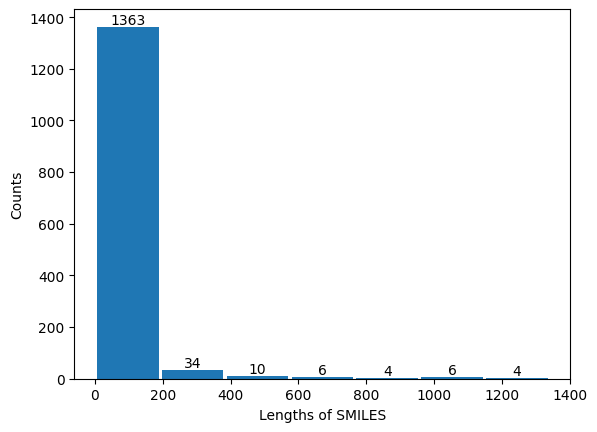

In [6]:
sider_smiles_lengths = sider_df['smiles'].apply(lambda smiles: len(smiles))
sider_smiles_lengths

n_bins = 7  # per 200-lengths
counts, edges, bars = plt.hist(sider_smiles_lengths, n_bins, rwidth=0.95)

plt.bar_label(bars)
plt.xlabel('Lengths of SMILES')
plt.ylabel('Counts')
plt.show()

Draw a molecule of a random SMILES from our dataset:

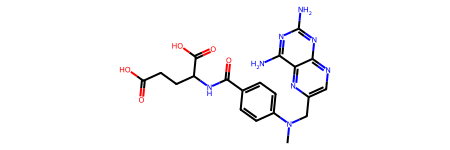

In [12]:
def draw_smile(smile):
    smile_mol = rdk.Chem.MolFromSmiles(smile)
    
    return smile_mol

def draw_random_smile():
    random_drug = sider_df.sample()
    random_drugs_smile = random_drug['smiles'].values[0]
    
    return draw_smile(random_drugs_smile)

draw_random_smile()

## Word embedding network

### Pub chem dataset

Load training SMILES: (pub_chem dataset, 442k)

In [13]:
pubchem_smiles_df = pd.read_csv('./data/smiles_embedding.csv')

In [14]:
pubchem_smiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444124 entries, 0 to 444123
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   CID        444124 non-null  int64 
 1   ISO_SMILE  444124 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.8+ MB


In [15]:
pubchem_smiles = pubchem_smiles_df['ISO_SMILE']

X_we_network = pubchem_smiles.sample(n=len(pubchem_smiles_df), random_state=SEED)

### Tokenization

Consists of two steps:
- tokenize SMILES using pre-trained substructure tokenizer based on [byte-pair-encoding (BPE)](https://aclanthology.org/P16-1162/)
    - https://pypi.org/project/SmilesPE/
- tokenize previously tokenized substructures based on their frequency using Tensorflow's Tokenizer


Load the pre-trained substructure tokenizer:

In [16]:
spe_vob = codecs.open('./models/SPE_ChEMBL.txt')
spe = SPE_Tokenizer(spe_vob)

Tokenize SMILES using pre-trained byte pair encoding model to substructure SMILES:

In [17]:
X_we_network_bpe_tokenized = [spe.tokenize(smile).split() for smile in X_we_network]

An example of a BPE tokenized SMILES:

In [19]:
X_we_network_bpe_tokenized[2]

['CC1',
 '=C2',
 'C=',
 'CC3',
 '=C(',
 'C2=C(',
 'C4',
 '=C1',
 'C(C(',
 'C=C',
 '4)',
 'O)',
 'O)',
 'C)',
 'C=CC(',
 '=C',
 '3)',
 'F']

Fit the second tokenizer on BPE tokenized SMILES:

In [20]:
frequency_tokenizer = tf.keras.preprocessing.text.Tokenizer()
frequency_tokenizer.fit_on_texts(X_we_network_bpe_tokenized)

Let's look at the vocabulary:

In [ ]:
frequency_tokenizer_vocabulary = frequency_tokenizer.word_index

frequency_tokenizer_vocabulary

how many unique substructures were found?

In [22]:
frequency_tokenizer_vocabulary_size = len(frequency_tokenizer_vocabulary)

frequency_tokenizer_vocabulary_size

2047

what are e.g. the five most frequent substructures?

In [23]:
list(map(lambda vocab_item: vocab_item[0], list(frequency_tokenizer_vocabulary.items())[:5]))

['cc', 'cc=', '=c(', '=', 'c1)']

Create tokenized sequences:

In [24]:
X_we_network_tokenized = frequency_tokenizer.texts_to_sequences(X_we_network_bpe_tokenized)

An example of such tokenized sequence:

In [25]:
X_we_network_tokenized[2]

[48, 19, 8, 41, 3, 50, 27, 31, 65, 12, 39, 11, 11, 36, 56, 9, 21, 118]

Word embedding network does not require an input of uniform length, but this workaround simplifies the process. Since our molecules have variable lengths, in the terms of count of their unique substructures, we need a way how turn them into sequences of uniform length. Typical way how to do it is to use a padding, specifically we will add 0's to the end of each sequence.

In [44]:
pubchem_max_bpe_tokenized_seq_size = max(len(seq) for seq in X_we_network_tokenized)

X_we_network_padded_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_we_network_tokenized, maxlen=pubchem_max_bpe_tokenized_seq_size, padding='post')

And an example of such input:

In [28]:
X_we_network_padded_tokenized[2]

array([ 48,  19,   8,  41,   3,  50,  27,  31,  65,  12,  39,  11,  11,
        36,  56,   9,  21, 118,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

### Autoencoder architecture

In [29]:
EMBEDDING_SIZE = 50

#### Encoder model

This model generates a word embedding from preprocessed SMILES:

In [45]:
# Define the shape of the input.
we_encoder_input = tf.keras.layers.Input(shape=(pubchem_max_bpe_tokenized_seq_size,), name='encoder_input')

# Apply L2 regularization that penalized big weights.
l2 = tf.keras.regularizers.L2(l2=0.01)

# Produces candidates for a word embedding.
we_encoder_embedding = tf.keras.layers.Embedding(
    input_dim=frequency_tokenizer_vocabulary_size + 1,
    output_dim=EMBEDDING_SIZE,
    input_length=pubchem_max_bpe_tokenized_seq_size,
    mask_zero=True,
    name='encoder_embedding'
)(we_encoder_input)

# Models temporal dependencies between the tokens in the input sequence.
we_rnn_cell = tf.keras.layers.LSTM(256, return_sequences=True, kernel_regularizer=l2)
we_encoder_rnn = tf.keras.layers.Bidirectional(we_rnn_cell, merge_mode='ave', name='encoder_rnn')(we_encoder_embedding)

# Average candidates.
we_encoder_avg_pool = tf.keras.layers.GlobalAveragePooling1D(name='encoder_avg_pool')(we_encoder_rnn)

# Process created word embedding.
we_encoder_dense = tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_regularizer=l2, name='encoder_fc_dense_1')(we_encoder_avg_pool)
we_encoder_dense_1 = tf.keras.layers.Dense(256 , activation=tf.nn.relu, kernel_regularizer=l2, name='encoder_fc_dense_2')(we_encoder_dense)

# Finally, the output of the model.
we_encoder_output = tf.keras.layers.Dense(EMBEDDING_SIZE , activation=tf.nn.relu, kernel_regularizer=l2, name='encoder_output')(we_encoder_dense_1)

we_encoder_model = tf.keras.Model(inputs=we_encoder_input, outputs=we_encoder_output, name='we_encoder')

In [32]:
we_encoder_model.summary()

Model: "we_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 358)]             0         
                                                                 
 encoder_embedding (Embeddin  (None, 358, 50)          102400    
 g)                                                              
                                                                 
 encoder_rnn (Bidirectional)  (None, 358, 256)         628736    
                                                                 
 encoder_avg_pool (GlobalAve  (None, 256)              0         
 ragePooling1D)                                                  
                                                                 
 encoder_fc_dense_1 (Dense)  (None, 256)               65792     
                                                                 
 encoder_fc_dense_2 (Dense)  (None, 256)               6

#### Decoder model

Takes the word embedding created by the encoder model and tries to reconstruct back the initial SMILES.

In [46]:
# Define the shape of the input which is the output of the encoder model.
we_decoder_input = tf.keras.layers.Input(shape=(EMBEDDING_SIZE,), name='decoder_input')

we_decoder_dense = tf.keras.layers.Dense(units=EMBEDDING_SIZE, activation=tf.nn.relu, kernel_regularizer=l2, name='decoder_fc_dense_1')(we_decoder_input)
we_decoder_dense_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu, kernel_regularizer=l2, name='decoder_fc_dense_2')(we_decoder_dense)
we_decoder_dense_2 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu, kernel_regularizer=l2, name='decoder_fc_dense_3')(we_decoder_dense_1)

we_decoder_output = tf.keras.layers.Dense(units=pubchem_max_bpe_tokenized_seq_size, kernel_regularizer=l2, name='decoder_output')(we_decoder_dense_2)

we_decoder_model = tf.keras.Model(inputs=we_decoder_input, outputs=we_decoder_output, name='we_decoder')

In [35]:
we_decoder_model.summary()

Model: "we_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 decoder_fc_dense_1 (Dense)  (None, 50)                2550      
                                                                 
 decoder_fc_dense_2 (Dense)  (None, 256)               13056     
                                                                 
 decoder_fc_dense_3 (Dense)  (None, 256)               65792     
                                                                 
 decoder_output (Dense)      (None, 358)               92006     
                                                                 
Total params: 173,404
Trainable params: 173,404
Non-trainable params: 0
_________________________________________________________________


#### Autoencoder model

Glue together both models into one network that learns to capture semantics of SMILES and return word embeddings for them:

In [47]:
we_network_input = we_encoder_input
we_network_output = we_decoder_model(we_encoder_output)

we_network_model = tf.keras.Model(inputs=we_network_input, outputs=we_network_output, name='we_network')

we_network_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(name="loss"),
)

In [37]:
we_network_model.summary()

Model: "we_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 358)]             0         
                                                                 
 encoder_embedding (Embeddin  (None, 358, 50)          102400    
 g)                                                              
                                                                 
 encoder_rnn (Bidirectional)  (None, 358, 256)         628736    
                                                                 
 encoder_avg_pool (GlobalAve  (None, 256)              0         
 ragePooling1D)                                                  
                                                                 
 encoder_fc_dense_1 (Dense)  (None, 256)               65792     
                                                                 
 encoder_fc_dense_2 (Dense)  (None, 256)               6

#### Pre-trained checkpoint

The training is a task for longer time. We trained the model on [metacentrum](https://metavo.metacentrum.cz/) and now we just load the pre-trained checkpoint:

In [49]:
we_network_model.load_weights('./models/we_network_50embdim_50epoch_bigger_everything_30.h5')

#### Reconstruct the encoder

In order to make word embeddings, we need only the encoder part of the autoencoder model.

In [50]:
we_network_encoder_input = we_network_model.get_layer('encoder_input').input
we_network_encoder_output = we_network_model.get_layer('encoder_output').output

we_network_encoder = tf.keras.Model(inputs=we_network_encoder_input, outputs=we_network_encoder_output, name='encoder_checkpoint')

In [40]:
we_network_encoder.summary()

Model: "encoder_checkpoint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 358)]             0         
                                                                 
 encoder_embedding (Embeddin  (None, 358, 50)          102400    
 g)                                                              
                                                                 
 encoder_rnn (Bidirectional)  (None, 358, 256)         628736    
                                                                 
 encoder_avg_pool (GlobalAve  (None, 256)              0         
 ragePooling1D)                                                  
                                                                 
 encoder_fc_dense_1 (Dense)  (None, 256)               65792     
                                                                 
 encoder_fc_dense_2 (Dense)  (None, 256)        

## Classificators

### Prepare training & validation & test data

Perform the same preprocessing steps as before training the word embedding network, because the inputs must be in the same form. We padded the sequences to uniform length of 358 which is the maximum count of unique substructures per one molecule in the pubchem data. Firstly we need to check what is the maximum count of unique substructures in the SIDER dataset. In order to do that, lets tokenize SMILES:

In [43]:
sider_bpe_tokenized = [spe.tokenize(smile).split() for smile in sider_df['smiles']]

the maximum count of unique substructures in the SIDER dataset is:

In [52]:
sider_max_bpe_tokenized_seq_size = max(len(seq) for seq in sider_bpe_tokenized)

sider_max_bpe_tokenized_seq_size

343

which is less than the number for pubchem data. This means that we are okay using the number from pubchem data. Now finish the preprocessing of SIDER SMILES:

In [53]:
sider_frequency_tokenizer = tf.keras.preprocessing.text.Tokenizer()
sider_frequency_tokenizer.fit_on_texts(sider_bpe_tokenized)

sider_tokenized = sider_frequency_tokenizer.texts_to_sequences(sider_bpe_tokenized)

sider_padded_tokenized = tf.keras.preprocessing.sequence.pad_sequences(sider_tokenized, maxlen=pubchem_max_bpe_tokenized_seq_size, padding='post')

SIDER frequency tokenizer vocabulary size:

In [54]:
len(sider_frequency_tokenizer.word_index)

824

Turn SIDER SMILES to word embedding:

In [55]:
sider_smiles_we = we_network_encoder.predict(sider_padded_tokenized)

45/45 [==============================] - 17s 310ms/step


Lets look at a random word embedding:

In [56]:
sider_smiles_we[0]

array([ 0.       ,  9.285371 ,  0.       ,  0.       ,  0.       ,
        0.       , 15.252752 ,  0.       ,  0.       , 12.33494  ,
        0.       ,  0.       ,  6.0125875,  0.       ,  0.       ,
       13.061996 ,  0.       ,  8.769304 , 19.361286 ,  0.       ,
       16.184898 ,  5.612869 ,  0.       ,  0.       , 11.585313 ,
        0.       ,  0.       , 13.13268  ,  7.0775757,  6.303573 ,
       10.610909 ,  8.067827 ,  0.       ,  0.       ,  0.       ,
        0.       , 12.559751 ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       , 10.827698 ,  0.       ,  0.       ,
       15.6738615,  7.7655687,  0.       ,  0.       ,  0.       ],
      dtype=float32)

Add a new column of word embedding representations to the SIDER dataset: 

In [57]:
sider_df['Word embedding'] = None
for we, (index, row) in zip(sider_smiles_we, sider_df.iterrows()):
    sider_df.at[index, 'Word embedding'] = we

### Class imbalance

We are dealing a with binary classification problem. Class imbalance can be a challenging issue. If the ratio of samples in the minority class is much lower than the ratio of majority class, say less than 10%, then the estimator might be biased towards the majority class.

Let's visualize whether we have equal distributions of negative and positive samples for each adverse drug reaction:

In [130]:
def calculate_class_imbalance(data):
    class_imbalances_df = pd.DataFrame(
        columns=[
            'ADR',
            'Negative count',
            'Positive count',
            'Count difference',
            'Minority ratio',
            'Majority ratio',
            'Ratio difference'
        ]
    )

    adr_columns, number_of_samples = data.columns[1:-1], len(data)
    for adr in adr_columns:
        adr_samples = data[adr]
        
        negatives = adr_samples[adr_samples == 0].size
        positives = adr_samples[adr_samples == 1].size
        
        count_difference = abs(negatives - positives)
        
        ratios = [round(negatives / number_of_samples * 100), round(positives / number_of_samples * 100)]
        minority_ratio, majority_ratio = sorted(ratios)
        
        ratio_difference = majority_ratio - minority_ratio
        
        row = [adr, negatives, positives, count_difference, minority_ratio, majority_ratio, ratio_difference]
        class_imbalances_df = pd.concat([class_imbalances_df, pd.DataFrame([row], columns=class_imbalances_df.columns)], ignore_index=True)

    def colorize_row(value):
        light_green = '#a6d96a'
        light_yellow = '#ffffbf'
        light_orange = '#fdae61'
        light_red = '#f46d43'
        dark_red = '#d73027'
        
        if value < 20:
            color = light_green
        elif 20 <= value < 40:
            color = light_yellow
        elif 40 <= value < 60:
            color = light_orange
        elif 60 <= value < 80:
            color = light_red
        elif 80 <= value:
            color = dark_red 
        
        return f'background-color: {color}'

    class_imbalances_df = class_imbalances_df.style.applymap(colorize_row, subset=['Ratio difference'])
    
    return class_imbalances_df

In [131]:
sider_class_imbalance_df = calculate_class_imbalance(sider_df)

sider_class_imbalance_df

,ADR,Negative count,Positive count,Count difference,Minority ratio,Majority ratio,Ratio difference
0,Hepatobiliary disorders,684,743,59,48,52,4
1,Metabolism and nutrition disorders,431,996,565,30,70,40
2,Product issues,1405,22,1383,2,98,96
3,Eye disorders,551,876,325,39,61,22
4,Investigations,276,1151,875,19,81,62
5,Musculoskeletal and connective tissue disorders,430,997,567,30,70,40
6,Gastrointestinal disorders,129,1298,1169,9,91,82
7,Social circumstances,1176,251,925,18,82,64
8,Immune system disorders,403,1024,621,28,72,44
9,Reproductive system and breast disorders,700,727,27,49,51,2


Not really, let's see what we can do with that.

#### Duplicate samples from the minority class

Probably the simplest approach, replicate observations of the minority class.

Firstly, let's prepare some functions:

In [164]:
def create_dataset(sider, adr):
    X, y = list(sider['Word embedding'].values), list(sider[adr].values)
    
    # 80:20 ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

Upsample the minority class by duplicating its rows:

In [181]:
sider_class_imbalance_df_T = sider_class_imbalance_df.data.set_index('ADR').transpose()

duplicated_datasets = []
for adr in sider_df.columns[1:-1]:
    ratio_difference = sider_class_imbalance_df_T[adr]['Ratio difference']
    if ratio_difference < 10:
        duplicated_datasets.append(create_dataset(sider_df, adr))

        continue
    
    samples_to_duplicate = round(ratio_difference / 100 * len(sider_df))
    minority_class = 0 if sider_class_imbalance_df_T[adr]['Negative count'] < sider_class_imbalance_df_T[adr]['Positive count'] else 1
    
    minority_class_samples = sider_df[sider_df[adr] == minority_class]
    duplicated_samples = minority_class_samples.sample(n=samples_to_duplicate, replace=True, random_state=SEED)
    
    duplicated_sider_df = pd.concat([sider_df, duplicated_samples], ignore_index=True)
    
    duplicated_datasets.append(create_dataset(duplicated_sider_df, adr))

Skipped:  Hepatobiliary disorders
Skipped:  Reproductive system and breast disorders
Skipped:  Ear and labyrinth disorders


##### Logistic regression

Define logistic regression for evaluation:

In [182]:
logistic_regression_clf = LogisticRegression(random_state=SEED)
logistic_regression_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['lbfgs', 'saga'],
}

logistic_regression_grid = GridSearchCV(estimator=logistic_regression_clf, param_grid=logistic_regression_param_grid)

Run logistic evaluation, make predictions:

In [183]:
duplicated_logistic_regressions = pd.DataFrame(columns=['ADR', 'Accuracy score', 'F1 score'])
for i, adr_dataset in enumerate(duplicated_datasets):
    X_train, X_test, y_train, y_test = adr_dataset
    
    logistic_regression_grid.fit(X_train, y_train)
    
    y_pred = logistic_regression_grid.best_estimator_.predict(X_test)

    accuracy = round(sklearn.metrics.accuracy_score(y_test, y_pred) * 100)
    f1_score = round(sklearn.metrics.f1_score(y_test, y_pred) * 100)
    
    row = [sider_df.columns[i + 1], f'{accuracy} %',  f'{f1_score} %']
    duplicated_logistic_regressions = pd.concat([duplicated_logistic_regressions, pd.DataFrame([row], columns=duplicated_logistic_regressions.columns)], ignore_index=True)

In [184]:
duplicated_logistic_regressions

,ADR,Accuracy score,F1 score
0,Hepatobiliary disorders,57 %,66 %
1,Metabolism and nutrition disorders,55 %,55 %
2,Product issues,67 %,65 %
3,Eye disorders,51 %,52 %
4,Investigations,53 %,51 %
5,Musculoskeletal and connective tissue disorders,56 %,57 %
6,Gastrointestinal disorders,60 %,57 %
7,Social circumstances,59 %,62 %
8,Immune system disorders,56 %,54 %
9,Reproductive system and breast disorders,59 %,60 %


##### Decision trees

In [169]:
decision_tree_clf = DecisionTreeClassifier(random_state=SEED)
decision_tree_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(start=3, stop=10, step=1),
    'max_features': np.arange(start=10, stop=50, step=5),
}

decision_tree_grid = GridSearchCV(estimator=decision_tree_clf, param_grid=decision_tree_param_grid)

In [170]:
duplicated_decision_trees = pd.DataFrame(columns=['ADR', 'Accuracy score', 'F1 score'])
for i, adr_dataset in enumerate(duplicated_datasets):
    X_train, X_test, y_train, y_test = adr_dataset
    
    decision_tree_grid.fit(X_train, y_train)
    
    y_pred = decision_tree_grid.best_estimator_.predict(X_test)

    accuracy = round(sklearn.metrics.accuracy_score(y_test, y_pred) * 100)
    f1_score = round(sklearn.metrics.f1_score(y_test, y_pred) * 100)
    
    row = [sider_df.columns[i + 1], f'{accuracy} %',  f'{f1_score} %']
    duplicated_decision_trees = pd.concat([duplicated_decision_trees, pd.DataFrame([row], columns=duplicated_decision_trees.columns)], ignore_index=True)

In [171]:
duplicated_decision_trees

,ADR,Accuracy score,F1 score
0,Hepatobiliary disorders,64 %,58 %
1,Metabolism and nutrition disorders,98 %,98 %
2,Product issues,59 %,53 %
3,Eye disorders,75 %,75 %
4,Investigations,62 %,62 %
5,Musculoskeletal and connective tissue disorders,78 %,78 %
6,Gastrointestinal disorders,73 %,77 %
7,Social circumstances,64 %,70 %
8,Immune system disorders,68 %,75 %
9,Reproductive system and breast disorders,87 %,85 %


In [172]:
import warnings
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

##### AdaBoost

In [178]:
ada_boost_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=SEED), random_state=SEED)
ada_boost_param_grid = {
    'n_estimators': [50, 100]
}

ada_boost_grid = GridSearchCV(estimator=ada_boost_clf, param_grid=ada_boost_param_grid)

In [179]:
duplicated_ada_boost = pd.DataFrame(columns=['ADR', 'Accuracy score', 'F1 score'])
for i, adr_dataset in enumerate(duplicated_datasets):
    X_train, X_test, y_train, y_test = adr_dataset
    
    ada_boost_grid.fit(X_train, y_train)
    
    y_pred = ada_boost_grid.best_estimator_.predict(X_test)

    accuracy = round(sklearn.metrics.accuracy_score(y_test, y_pred) * 100)
    f1_score = round(sklearn.metrics.f1_score(y_test, y_pred) * 100)
    
    row = [sider_df.columns[i + 1], f'{accuracy} %',  f'{f1_score} %']
    duplicated_ada_boost = pd.concat([duplicated_ada_boost, pd.DataFrame([row], columns=duplicated_ada_boost.columns)], ignore_index=True)

In [180]:
duplicated_ada_boost

,ADR,Accuracy score,F1 score
0,Hepatobiliary disorders,76 %,71 %
1,Metabolism and nutrition disorders,100 %,100 %
2,Product issues,66 %,64 %
3,Eye disorders,85 %,84 %
4,Investigations,77 %,73 %
5,Musculoskeletal and connective tissue disorders,95 %,95 %
6,Gastrointestinal disorders,88 %,90 %
7,Social circumstances,80 %,78 %
8,Immune system disorders,83 %,85 %
9,Reproductive system and breast disorders,94 %,93 %
